#**스마트폰 센서 데이터 기반 모션 분류**
# 단계3 : 단계별 모델링


## 0.미션

단계별로 나눠서 모델링을 수행하고자 합니다.  

* 단계1 : 정적(0), 동적(1) 행동 분류 모델 생성
* 단계2 : 세부 동작에 대한 분류모델 생성
    * 단계1 모델에서 0으로 예측 -> 정적 행동 3가지 분류 모델링
    * 단계1 모델에서 1으로 예측 -> 동적 행동 3가지 분류 모델링
* 모델 통합
    * 두 단계 모델을 통합하고, 새로운 데이터에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
* 성능 비교
    * 기본 모델링의 성능과 비교
    * 모든 모델링은 [다양한 알고리즘 + 성능 튜닝]을 수행해야 합니다.


## 1.환경설정

### (1) 라이브러리 불러오기

* 세부 요구사항
    - 기본적으로 필요한 라이브러리를 import 하도록 코드가 작성되어 있습니다.
    - 필요하다고 판단되는 라이브러리를 추가하세요.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import joblib

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from lightgbm import LGBMClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

from sklearn.metrics import *

# import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Flatten, Dropout
from keras.backend import clear_session
from keras.optimizers import Adam

### (2) 데이터 불러오기

* 주어진 데이터셋
    * data01_train.csv : 학습 및 검증용

 <br/>  

* 세부 요구사항
    - data01_train.csv 를 불러와 'data' 이름으로 저장합니다.
        - data에서 변수 subject는 삭제합니다.
    - data01_test.csv 를 불러와 'new_data' 이름으로 저장합니다.


In [3]:
path = '/content/drive/MyDrive/deep_learning/MP3/'

In [4]:
data = pd.read_csv(path + 'data01_train.csv')
data.drop('subject', axis=1, inplace=True)
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.004012,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.157832,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS


In [5]:
data_bk = data.copy()

## 2.데이터 전처리

* 세부 요구사항
    - Label 추가 : data 에 Activity_dynamic 를 추가합니다. Activity_dynamic은 과제1에서 is_dynamic과 동일한 값입니다.
    - x와 y1, y2로 분할하시오.
        * y1 : Activity
        * y2 : Activity_dynamic
    - train : val = 8 : 2 혹은 7 : 3
    - random_state 옵션을 사용하여 다른 모델과 비교를 위해 성능이 재현되도록 합니다.

In [6]:
is_dynamic = data['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                  'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
is_dynamic

0       0
1       0
2       0
3       1
4       1
       ..
5876    0
5877    1
5878    0
5879    1
5880    0
Name: Activity, Length: 5881, dtype: int64

In [7]:
data['Activity_dynamic'] = is_dynamic
data.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,STANDING,0
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,LAYING,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,STANDING,0
3,0.289795,-0.035536,-0.150354,-0.231727,-0.006412,-0.338117,-0.273557,0.014245,-0.347916,0.008288,...,-0.408956,-0.255125,0.612804,0.747381,-0.072944,-0.695819,0.287154,0.111388,WALKING,1
4,0.394807,0.034098,0.091229,0.088489,-0.106636,-0.388502,-0.010469,-0.109680,-0.346372,0.584131,...,-0.563437,-0.044344,-0.845268,-0.974650,-0.887846,-0.705029,0.264952,0.137758,WALKING_DOWNSTAIRS,1


In [8]:
x = data.drop(['Activity', 'Activity_dynamic'], axis=1)
y1 = data['Activity']
y2 = data['Activity_dynamic']
x_train, x_val, y1_train, y1_val, y2_train, y2_val = train_test_split(x, y1, y2, test_size=.3, random_state=2024)

## **3.단계별 모델링**

![](https://github.com/DA4BAM/image/blob/main/step%20by%20step.png?raw=true)

### (1) 단계1 : 정적/동적 행동 분류 모델

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)과 동적 행동(동적 : Walking, Walking-Up, Walking-Down)을 구분하는 모델 생성.
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

#### 1) 알고리즘1 :

In [9]:
m1 = RandomForestClassifier()
m1.fit(x_train, y2_train)
p1 = m1.predict(x_val)

print('accuracy :',accuracy_score(y2_val, p1))
print('='*60)
print(confusion_matrix(y2_val, p1))
print('='*60)
print(classification_report(y2_val, p1))

accuracy : 0.9994334277620397
[[956   1]
 [  0 808]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       957
           1       1.00      1.00      1.00       808

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [10]:
result = pd.DataFrame({'algorithm':[],'accuracy':[]})
acc = accuracy_score(y2_val, p1)
row = ['rf', acc]
result.loc[0] = row
result.head()

,algorithm,accuracy
0,rf,0.999433


#### 2) 알고리즘2 : Logistic Regression

In [11]:
m2 = LogisticRegression()
m2.fit(x_train, y2_train)
p2 = m2.predict(x_val)

acc = accuracy_score(y2_val, p2)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y2_val, p2))
print('='*60)
print(classification_report(y2_val, p2))

accuracy : 0.9994334277620397
[[956   1]
 [  0 808]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       957
           1       1.00      1.00      1.00       808

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [12]:
row = ['lr', acc]
result.loc[1] = row
result.head()

,algorithm,accuracy
0,rf,0.999433
1,lr,0.999433


# 알고리즘 3: XGB

In [13]:
m3 = XGBClassifier()
m3.fit(x_train, y2_train)
p3 = m3.predict(x_val)

acc = accuracy_score(y2_val, p3)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y2_val, p3))
print('='*60)
print(classification_report(y2_val, p3))

accuracy : 1.0
[[957   0]
 [  0 808]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       957
           1       1.00      1.00      1.00       808

    accuracy                           1.00      1765
   macro avg       1.00      1.00      1.00      1765
weighted avg       1.00      1.00      1.00      1765



In [14]:
row = ['xgb', acc]
result.loc[2] = row
result.head()

,algorithm,accuracy
0,rf,0.999433
1,lr,0.999433
2,xgb,1.000000


### (2) 단계2-1 : 정적 동작 세부 분류

* 세부 요구사항
    * 정적 행동(Laying, Sitting, Standing)인 데이터 추출
    * Laying, Sitting, Standing 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [15]:
data_static = data_bk.copy()
target_map = ['LAYING', 'SITTING', 'STANDING']
data_static = data_static[data_static['Activity'].isin(target_map)]

In [16]:
static_map = {'LAYING': 0, 'SITTING': 1, 'STANDING': 2}
data_static['Activity'] = data_static['Activity'].map(static_map)
data_static.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.288508,-0.009196,-0.103362,-0.988986,-0.962797,-0.967422,-0.989000,-0.962596,-0.965650,-0.929747,...,-0.487737,-0.816696,-0.042494,-0.044218,0.307873,0.072790,-0.601120,0.331298,0.165163,2
1,0.265757,-0.016576,-0.098163,-0.989551,-0.994636,-0.987435,-0.990189,-0.993870,-0.987558,-0.937337,...,-0.237820,-0.693515,-0.062899,0.388459,-0.765014,0.771524,0.345205,-0.769186,-0.147944,0
2,0.278709,-0.014511,-0.108717,-0.997720,-0.981088,-0.994008,-0.997934,-0.982187,-0.995017,-0.942584,...,-0.535287,-0.829311,0.000265,-0.525022,-0.891875,0.021528,-0.833564,0.202434,-0.032755,2
7,0.272026,-0.001329,-0.125491,-0.992068,-0.912985,-0.972451,-0.994752,-0.943141,-0.976428,-0.925446,...,-0.258503,-0.704995,-0.024442,0.076332,0.741277,0.729812,-0.817201,0.037746,0.136129,2
8,0.284338,0.021956,-0.006925,-0.980153,-0.838394,-0.782357,-0.983683,-0.816199,-0.743923,-0.914011,...,-0.052863,-0.400197,0.021212,-0.009465,-0.282762,0.563343,-0.782072,0.242834,-0.025285,2


In [17]:
# x, y 분류
target = 'Activity'
x = data_static.drop(target, axis=1)
y = data_static[target]

# test, train split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state=2024)

In [18]:
y_train.value_counts()

2    781
0    757
1    725
Name: Activity, dtype: int64

## 모델링 1: Random Forest

In [19]:
ms_1 = RandomForestClassifier()
ms_1.fit(x_train, y_train)
ps_1 = ms_1.predict(x_val)

acc = accuracy_score(y_val, ps_1)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y_val, ps_1))
print('='*60)
print(classification_report(y_val, ps_1))

accuracy : 0.9742533470648815
[[358   0   0]
 [  0 295  12]
 [  0  13 293]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       358
           1       0.96      0.96      0.96       307
           2       0.96      0.96      0.96       306

    accuracy                           0.97       971
   macro avg       0.97      0.97      0.97       971
weighted avg       0.97      0.97      0.97       971



In [20]:
result_static = pd.DataFrame({'algorithm':[],'accuracy':[]})
acc = accuracy_score(y_val, ps_1)
row = ['rf', acc]
result_static.loc[0] = row
result_static.head()

,algorithm,accuracy
0,rf,0.974253


## 모델2 : Logistic Regression

In [21]:
ms_2 = LogisticRegression()
ms_2.fit(x_train, y_train)
ps_2 = ms_2.predict(x_val)

acc = accuracy_score(y_val, ps_2)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y_val, ps_2))
print('='*60)
print(classification_report(y_val, ps_2))

accuracy : 0.9752832131822863
[[358   0   0]
 [  0 294  13]
 [  0  11 295]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       358
           1       0.96      0.96      0.96       307
           2       0.96      0.96      0.96       306

    accuracy                           0.98       971
   macro avg       0.97      0.97      0.97       971
weighted avg       0.98      0.98      0.98       971



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [22]:
acc = accuracy_score(y_val, ps_2)
row = ['lr', acc]
result_static.loc[1] = row
result_static.head()

,algorithm,accuracy
0,rf,0.974253
1,lr,0.975283


## 모델3 : 딥러닝

In [23]:
# 스케일링

scaler = MinMaxScaler()
x_train_s = scaler.fit_transform(x_train)
x_val_s = scaler.transform(x_val)

In [24]:
x_train.shape[1]

561

In [25]:
clear_session()
# 모델링
nfeatures = x_train.shape[1]
ms_3 = Sequential(
   [ Dense(256, input_shape = (nfeatures,), activation = 'relu'),
    Dense(64, activation = 'relu'),
    Dense(3, activation = 'softmax') ]
    )

# 요약
ms_3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 256)               143872    
                                                                 
 dense_1 (Dense)             (None, 64)                16448     
                                                                 
 dense_2 (Dense)             (None, 3)                 195       
                                                                 
Total params: 160515 (627.01 KB)
Trainable params: 160515 (627.01 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [26]:
def dl_history_plot(history):
    plt.figure(figsize=(10,6))
    plt.plot(history['loss'], label='train_err', marker = '.')
    plt.plot(history['val_loss'], label='val_err', marker = '.')

    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid()
    plt.show()

In [27]:
lr = 0.01
epo = 50
ms_3.compile(optimizer=Adam(learning_rate=lr), loss='sparse_categorical_crossentropy')
hist = ms_3.fit(x_train_s, y_train, validation_split=.2, epochs=epo ,verbose=0).history

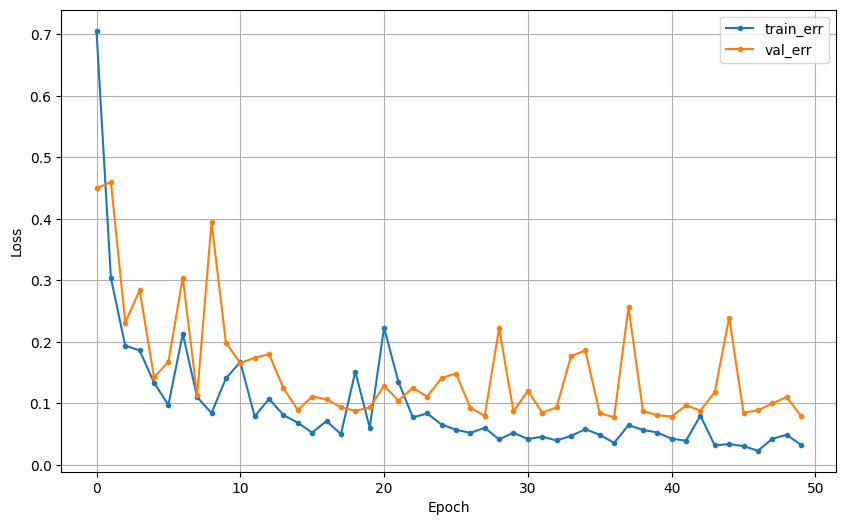

In [28]:
dl_history_plot(hist)

In [29]:
ps_3 = ms_3.predict(x_val_s)
ps_3 = np.argmax(ps_3, axis = 1)

# 평가
acc = accuracy_score(y_val, ps_3)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y_val, ps_3))
print('='*60)
print(classification_report(y_val, ps_3))

31/31 [==============================] - 0s 2ms/step
accuracy : 0.9742533470648815
[[358   0   0]
 [  1 295  11]
 [  0  13 293]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       358
           1       0.96      0.96      0.96       307
           2       0.96      0.96      0.96       306

    accuracy                           0.97       971
   macro avg       0.97      0.97      0.97       971
weighted avg       0.97      0.97      0.97       971



In [30]:
row = ['dl', acc]
result_static.loc[2] = row
result_static.head()

,algorithm,accuracy
0,rf,0.974253
1,lr,0.975283
2,dl,0.974253


### (3) 단계2-2 : 동적 동작 세부 분류

* 세부 요구사항
    * 동적 행동(Walking, Walking Upstairs, Walking Downstairs)인 데이터 추출
    * Walking, Walking Upstairs, Walking Downstairs 를 분류하는 모델을 생성
    * 몇가지 모델을 만들고 가장 성능이 좋은 모델을 선정하시오.

In [31]:
data_dynamic = data_bk.copy()
target_map = ['WALKING', 'WALKING_UPSTAIRS', 'WALKING_DOWNSTAIRS']
data_dynamic = data_dynamic[data_dynamic['Activity'].isin(target_map)]
data_dynamic['Activity'].value_counts()

WALKING               998
WALKING_UPSTAIRS      858
WALKING_DOWNSTAIRS    791
Name: Activity, dtype: int64

In [32]:
dynamic_map = {'WALKING': 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2}
target = 'Activity'
data_dynamic[target] = data_dynamic[target].map(dynamic_map)
data_dynamic[target].value_counts()

0    998
1    858
2    791
Name: Activity, dtype: int64

In [33]:
# x, y 분류
target = 'Activity'
x = data_dynamic.drop(target, axis=1)
y = data_dynamic[target]

# test, train split
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=.3, random_state=2024)

## 모델1: Randomforest

In [34]:
md_1 = RandomForestClassifier()
md_1.fit(x_train, y_train)
pd_1 = md_1.predict(x_val)

acc = accuracy_score(y_val, pd_1)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y_val, pd_1))
print('='*60)

result_dynamic = pd.DataFrame({'algorithm':[],'accuracy':[]})
row = ['rf', acc]
result_dynamic.loc[0] = row
result_dynamic.head()

accuracy : 0.9773584905660377
[[310   2   7]
 [  0 246   3]
 [  2   4 221]]


,algorithm,accuracy
0,rf,0.977358


## 모델2 : LGBM

In [35]:
import re
x_train_lgbm = x_train.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

In [36]:
md_2 = LGBMClassifier()
md_2.fit(x_train_lgbm, y_train)
pd_2 = md_2.predict(x_val)

acc = accuracy_score(y_val, pd_2)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y_val, pd_2))
print('='*60)
print(classification_report(y_val, pd_2))

row = ['lgbm', acc]
result_dynamic.loc[1] = row
result_dynamic.head()

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.016186 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 139778
[LightGBM] [Info] Number of data points in the train set: 1852, number of used features: 561
[LightGBM] [Info] Start training from score -1.003400
[LightGBM] [Info] Start training from score -1.112203
[LightGBM] [Info] Start training from score -1.188967
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] N

,algorithm,accuracy
0,rf,0.977358
1,lgbm,0.994969


## 모델3: Logistic Regression

In [37]:
md_3 = LogisticRegression()
md_3.fit(x_train, y_train)
pd_3 = md_3.predict(x_val)

acc = accuracy_score(y_val, pd_3)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y_val, pd_3))
print('='*60)
print(classification_report(y_val, pd_3))

row = ['lr', acc]
result_dynamic.loc[2] = row
result_dynamic.head()

accuracy : 0.9962264150943396
[[318   1   0]
 [  1 248   0]
 [  1   0 226]]
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       319
           1       1.00      1.00      1.00       249
           2       1.00      1.00      1.00       227

    accuracy                           1.00       795
   macro avg       1.00      1.00      1.00       795
weighted avg       1.00      1.00      1.00       795



/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,algorithm,accuracy
0,rf,0.977358
1,lgbm,0.994969
2,lr,0.996226


## 모델4: xgb

In [38]:
md_4 = XGBClassifier()

md_4.fit(x_train, y_train)
pd_4 = md_4.predict(x_val)

acc = accuracy_score(y_val, pd_4)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y_val, pd_4))
print('='*60)
print(classification_report(y_val, pd_4))

row = ['xgb', acc]
result_dynamic.loc[3] = row
result_dynamic.head()

accuracy : 0.989937106918239
[[316   1   2]
 [  0 247   2]
 [  1   2 224]]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       319
           1       0.99      0.99      0.99       249
           2       0.98      0.99      0.98       227

    accuracy                           0.99       795
   macro avg       0.99      0.99      0.99       795
weighted avg       0.99      0.99      0.99       795



,algorithm,accuracy
0,rf,0.977358
1,lgbm,0.994969
2,lr,0.996226
3,xgb,0.989937


In [39]:
result

,algorithm,accuracy
0,rf,0.999433
1,lr,0.999433
2,xgb,1.000000


In [40]:
result_static

,algorithm,accuracy
0,rf,0.974253
1,lr,0.975283
2,dl,0.974253


In [41]:
result_dynamic

,algorithm,accuracy
0,rf,0.977358
1,lgbm,0.994969
2,lr,0.996226
3,xgb,0.989937


### [선택사항] (4) 분류 모델 합치기


* 세부 요구사항
    * 두 단계 모델을 통합하고, 새로운 데이터(test)에 대해서 최종 예측결과와 성능평가가 나오도록 함수로 만들기
    * 데이터 파이프라인 구축 : test데이터가 로딩되어 전처리 과정을 거치고, 예측 및 성능 평가 수행

![](https://github.com/DA4BAM/image/blob/main/pipeline%20function.png?raw=true)

#### 1) 함수 만들어서 분류 모델 합치기

In [42]:
test = pd.read_csv(path + 'data01_test.csv')
test.drop('subject', axis=1,inplace=True)
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING


In [43]:
test.shape

(1471, 562)

In [44]:
is_dynamic = test['Activity'].map({'STANDING':0, 'SITTING':0, 'LAYING':0,
                  'WALKING':1, 'WALKING_UPSTAIRS':1, 'WALKING_DOWNSTAIRS':1})
is_dynamic

test['Activity_dynamic'] = is_dynamic
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING,0
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING,0
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING,1
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING,0
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING,0


# 이진분류: rf

In [45]:
# Random Forest

activity_bk = test['Activity']
target = 'Activity_dynamic'

x_test = test.drop([target, 'Activity'], axis=1)
y_test = test[target]

y_pred = m1.predict(x_test)
print(y_pred)

[0 0 1 ... 1 0 1]


In [46]:
# 데이터 다시 합치기
test['Activity'] = activity_bk
test['pred'] = y_pred

In [47]:
test_static = test.loc[test['pred'] == 0]
test_dynamic = test.loc[test['pred'] == 1]

In [48]:
test_static.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic,pred
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING,0,0
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING,0,0
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING,0,0
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING,0,0
6,0.447718,0.207096,-0.117430,-0.843029,-0.101380,-0.553765,-0.849087,-0.049920,-0.552505,-0.710284,...,-0.052553,0.173963,-0.214500,-0.259947,-0.794966,0.233738,-0.024725,STANDING,0,0


In [49]:
print(accuracy_score(y_test, y_pred))

1.0


### static 모델 수행: rf

In [50]:
# static 모델 수행
test_static.drop(['Activity_dynamic', 'pred'], axis=1, inplace=True)

<ipython-input-50-a75a59e8ffae>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_static.drop(['Activity_dynamic', 'pred'], axis=1, inplace=True)


In [51]:
test_static['Activity'].value_counts()

LAYING      292
STANDING    287
SITTING     254
Name: Activity, dtype: int64

In [52]:
static_map = {'LAYING': 0, 'SITTING': 1, 'STANDING': 2}
test_static['Activity'] = test_static['Activity'].map(static_map)
test_static.head()

<ipython-input-52-38ee734ac260>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_static['Activity'] = test_static['Activity'].map(static_map)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.509523,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,1
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.210792,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,2
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.566291,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,1
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.447577,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,2
6,0.447718,0.207096,-0.117430,-0.843029,-0.101380,-0.553765,-0.849087,-0.049920,-0.552505,-0.710284,...,-0.298895,-0.595825,-0.052553,0.173963,-0.214500,-0.259947,-0.794966,0.233738,-0.024725,2


In [53]:
test_static['Activity'].value_counts()

0    292
2    287
1    254
Name: Activity, dtype: int64

In [54]:
target = 'Activity'
x_test = test_static.drop(target, axis=1)
y_test = test_static[target]

y_pred_2_1 = ms_1.predict(x_test)
test_static['static_pred'] = y_pred_2_1

<ipython-input-54-549aa217f2af>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_static['static_pred'] = y_pred_2_1


In [55]:
test_static.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,static_pred
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,1,1
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,2,2
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,1,1
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,2,2
6,0.447718,0.207096,-0.117430,-0.843029,-0.101380,-0.553765,-0.849087,-0.049920,-0.552505,-0.710284,...,-0.595825,-0.052553,0.173963,-0.214500,-0.259947,-0.794966,0.233738,-0.024725,2,2


In [56]:
print(accuracy_score(y_test, y_pred_2_1))

0.9603841536614646


### dynamic 모델 수행: lr

In [57]:
# dynamic 모델 수행
test_dynamic.drop(['Activity_dynamic', 'pred'], axis=1, inplace=True)
test_dynamic

<ipython-input-57-eb7858f371d8>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dynamic.drop(['Activity_dynamic', 'pred'], axis=1, inplace=True)


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-skewness(),fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.579587,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING
5,0.336801,0.010528,-0.057819,-0.435988,-0.126317,0.037931,-0.446406,-0.244650,-0.034606,-0.288437,...,0.115015,-0.351891,-0.174328,0.558749,0.664988,0.544573,-0.775712,0.187548,0.149686,WALKING
9,0.087902,-0.118993,-0.052787,-0.217817,-0.148752,0.079020,-0.294967,-0.165066,0.137718,0.070103,...,-0.535753,-0.842876,0.313940,0.577018,-0.968008,0.525585,-0.872144,0.186079,0.007999,WALKING_UPSTAIRS
16,0.267601,-0.032814,-0.113073,-0.290751,0.028228,-0.011504,-0.341515,0.043469,0.048429,-0.226421,...,-0.475586,-0.795217,-0.082706,0.206094,-0.917195,-0.365769,-0.616598,0.353675,0.087181,WALKING_UPSTAIRS
17,0.187920,-0.022493,-0.114320,-0.285203,-0.001438,0.163397,-0.339592,-0.134192,0.172202,0.093298,...,-0.381085,-0.806618,0.765867,-0.099255,0.815948,0.007978,-0.796053,0.199388,0.119815,WALKING
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1459,0.330787,0.003088,-0.119242,-0.031168,0.153938,-0.347749,-0.102352,0.154328,-0.372959,0.189891,...,-0.522999,-0.821387,-0.273972,0.164241,0.698665,0.793528,-0.553123,0.367753,0.166578,WALKING_UPSTAIRS
1462,0.305610,-0.016737,-0.030036,0.127349,0.144149,0.028455,0.061540,0.193795,0.013134,0.443721,...,-0.112557,-0.463861,0.076715,0.332003,-0.928488,-0.360979,-0.640240,0.194490,0.255591,WALKING_DOWNSTAIRS
1463,0.333934,-0.015675,-0.125687,0.076394,-0.187450,0.144608,-0.023927,-0.231563,0.102194,0.557096,...,-0.205663,-0.553521,-0.858843,-0.601687,0.893242,0.674606,-0.680206,0.165492,0.237212,WALKING_DOWNSTAIRS
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,-0.213340,-0.615554,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201,WALKING_DOWNSTAIRS


In [58]:
test_dynamic['Activity'].value_counts()

WALKING               228
WALKING_UPSTAIRS      215
WALKING_DOWNSTAIRS    195
Name: Activity, dtype: int64

In [59]:
dynamic_map = {'WALKING': 0, 'WALKING_UPSTAIRS': 1, 'WALKING_DOWNSTAIRS': 2}
test_dynamic['Activity'] = test_dynamic['Activity'].map(dynamic_map)
test_dynamic['Activity'].value_counts()

<ipython-input-59-e6310ddcf6f9>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dynamic['Activity'] = test_dynamic['Activity'].map(dynamic_map)


0    228
1    215
2    195
Name: Activity, dtype: int64

In [60]:
target = 'Activity'
x_test = test_dynamic.drop(target, axis=1)
y_test = test_dynamic[target]

y_pred_2_2 = md_3.predict(x_test)
test_dynamic['dynamic_pred'] = y_pred_2_2
test_dynamic.head()

<ipython-input-60-1163bbc397a4>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dynamic['dynamic_pred'] = y_pred_2_2


,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,dynamic_pred
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,0,0
5,0.336801,0.010528,-0.057819,-0.435988,-0.126317,0.037931,-0.446406,-0.244650,-0.034606,-0.288437,...,-0.351891,-0.174328,0.558749,0.664988,0.544573,-0.775712,0.187548,0.149686,0,0
9,0.087902,-0.118993,-0.052787,-0.217817,-0.148752,0.079020,-0.294967,-0.165066,0.137718,0.070103,...,-0.842876,0.313940,0.577018,-0.968008,0.525585,-0.872144,0.186079,0.007999,1,1
16,0.267601,-0.032814,-0.113073,-0.290751,0.028228,-0.011504,-0.341515,0.043469,0.048429,-0.226421,...,-0.795217,-0.082706,0.206094,-0.917195,-0.365769,-0.616598,0.353675,0.087181,1,1
17,0.187920,-0.022493,-0.114320,-0.285203,-0.001438,0.163397,-0.339592,-0.134192,0.172202,0.093298,...,-0.806618,0.765867,-0.099255,0.815948,0.007978,-0.796053,0.199388,0.119815,0,0


In [61]:
print(accuracy_score(y_test, y_pred_2_2))

0.9984326018808778


# 데이터를 합치기 전에 pred 값을 원상복구

In [62]:
test_static['static_pred'] = test_static['static_pred'].map({0: 'LAYING', 1: 'SITTING', 2: 'STANDING'})
test_static['static_pred'].value_counts()

<ipython-input-62-8fa10ddb9211>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_static['static_pred'] = test_static['static_pred'].map({0: 'LAYING', 1: 'SITTING', 2: 'STANDING'})


LAYING      291
STANDING    281
SITTING     261
Name: static_pred, dtype: int64

In [63]:
test_dynamic['dynamic_pred'] = test_dynamic['dynamic_pred'].map({0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS'})
test_dynamic['dynamic_pred'].value_counts()

<ipython-input-63-25bbebc8fe59>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dynamic['dynamic_pred'] = test_dynamic['dynamic_pred'].map({0: 'WALKING', 1: 'WALKING_UPSTAIRS', 2: 'WALKING_DOWNSTAIRS'})


WALKING               229
WALKING_UPSTAIRS      214
WALKING_DOWNSTAIRS    195
Name: dynamic_pred, dtype: int64

In [64]:
test_static.rename(columns={'static_pred': 'Activity_pred'}, inplace=True)
test_dynamic.rename(columns={'dynamic_pred': 'Activity_pred'}, inplace=True)

<ipython-input-64-fd17dfd4cd66>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_static.rename(columns={'static_pred': 'Activity_pred'}, inplace=True)
<ipython-input-64-fd17dfd4cd66>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_dynamic.rename(columns={'dynamic_pred': 'Activity_pred'}, inplace=True)


In [65]:
static_pred = test_static['Activity_pred']
static_pred

0        SITTING
1       STANDING
3        SITTING
4       STANDING
6       STANDING
          ...   
1464     SITTING
1465     SITTING
1466     SITTING
1467    STANDING
1469      LAYING
Name: Activity_pred, Length: 833, dtype: object

In [66]:
dynamic_pred = test_dynamic['Activity_pred']
dynamic_pred

2                  WALKING
5                  WALKING
9         WALKING_UPSTAIRS
16        WALKING_UPSTAIRS
17                 WALKING
               ...        
1459      WALKING_UPSTAIRS
1462    WALKING_DOWNSTAIRS
1463    WALKING_DOWNSTAIRS
1468    WALKING_DOWNSTAIRS
1470    WALKING_DOWNSTAIRS
Name: Activity_pred, Length: 638, dtype: object

In [67]:
static_pred_t = pd.DataFrame({'idx': static_pred.index, 'pred': static_pred})
static_pred_t.set_index('idx', inplace=True)
for idx, row in static_pred_t.iterrows():
  test.loc[idx, 'Activity_pred'] = row['pred']

test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic,pred,Activity_pred
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING,0,0,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING,0,0,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING,1,1,NaN
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING,0,0,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING,0,0,STANDING


In [68]:
dynamic_pred_t = pd.DataFrame({'idx': dynamic_pred.index, 'pred': dynamic_pred})
dynamic_pred_t.set_index('idx', inplace=True)
for idx, row in dynamic_pred_t.iterrows():
  test.loc[idx, 'Activity_pred'] = row['pred']

test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,"angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_dynamic,pred,Activity_pred
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING,0,0,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING,0,0,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING,1,1,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING,0,0,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING,0,0,STANDING


In [70]:
test.drop(['Activity_dynamic', 'pred'], axis=1, inplace=True)

In [71]:
test.head()

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_pred
0,0.284379,-0.021981,-0.116683,-0.992490,-0.979640,-0.963321,-0.992563,-0.977304,-0.958142,-0.938850,...,-0.850065,-0.018043,0.092304,0.074220,-0.714534,-0.671943,-0.018351,-0.185733,SITTING,SITTING
1,0.277440,-0.028086,-0.118412,-0.996620,-0.927676,-0.972294,-0.997346,-0.931405,-0.971788,-0.939837,...,-0.613367,-0.022456,-0.155414,0.247498,-0.112257,-0.826816,0.184489,-0.068699,STANDING,STANDING
2,0.305833,-0.041023,-0.087303,0.006880,0.182800,-0.237984,0.005642,0.028616,-0.236474,0.016311,...,0.394388,-0.362616,0.171069,0.576349,-0.688314,-0.743234,0.272186,0.053101,WALKING,WALKING
3,0.276053,-0.016487,-0.108381,-0.995379,-0.983978,-0.975854,-0.995877,-0.985280,-0.974907,-0.941425,...,-0.841455,0.289548,0.079801,-0.020033,0.291898,-0.639435,-0.111998,-0.123298,SITTING,SITTING
4,0.271998,0.016904,-0.078856,-0.973468,-0.702462,-0.869450,-0.979810,-0.711601,-0.856807,-0.920760,...,0.214219,0.010111,0.114179,-0.830776,-0.325098,-0.840817,0.116237,-0.096615,STANDING,STANDING


In [72]:
tmp = test.copy()
tmp.loc[tmp['Activity_pred'] == 'WALKING_DOWNSTAIRS']

,tBodyAcc-mean()-X,tBodyAcc-mean()-Y,tBodyAcc-mean()-Z,tBodyAcc-std()-X,tBodyAcc-std()-Y,tBodyAcc-std()-Z,tBodyAcc-mad()-X,tBodyAcc-mad()-Y,tBodyAcc-mad()-Z,tBodyAcc-max()-X,...,fBodyBodyGyroJerkMag-kurtosis(),"angle(tBodyAccMean,gravity)","angle(tBodyAccJerkMean),gravityMean)","angle(tBodyGyroMean,gravityMean)","angle(tBodyGyroJerkMean,gravityMean)","angle(X,gravityMean)","angle(Y,gravityMean)","angle(Z,gravityMean)",Activity,Activity_pred
18,0.143609,0.002423,-0.119384,0.199690,0.422328,-0.223397,0.129353,0.366185,-0.221930,0.401342,...,-0.476662,0.890240,-0.945232,0.759660,0.679176,-0.777405,0.251605,0.028866,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
23,0.274954,-0.014241,-0.103103,-0.157768,-0.369564,-0.118826,-0.251849,-0.385764,-0.169361,0.174231,...,-0.586227,0.338181,0.911199,0.798932,-0.159453,-0.685168,0.166079,0.233261,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
25,0.268337,0.006621,-0.114554,-0.010440,0.448861,0.561032,-0.135364,0.314269,0.549132,0.636017,...,-0.669242,0.212143,-0.691855,0.820964,-0.100657,-0.472493,0.281620,0.337713,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
35,0.251557,-0.020543,-0.040557,0.174721,-0.331197,-0.214243,0.120931,-0.414366,-0.247148,0.389251,...,-0.653827,0.116302,0.862839,-0.874876,0.073629,-0.924158,0.131677,-0.025066,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
38,0.289279,-0.017182,-0.168587,0.193132,0.212081,-0.425031,0.169663,0.195031,-0.410475,0.257486,...,-0.840941,-0.108863,-0.559960,-0.866648,0.420848,-0.748328,0.266316,0.063213,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1457,0.210201,-0.047523,-0.030040,-0.200168,-0.037916,-0.269186,-0.306813,-0.081269,-0.263518,0.430177,...,-0.666595,0.238628,-0.210275,-0.576230,-0.929161,-0.850660,0.200635,0.030983,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
1462,0.305610,-0.016737,-0.030036,0.127349,0.144149,0.028455,0.061540,0.193795,0.013134,0.443721,...,-0.463861,0.076715,0.332003,-0.928488,-0.360979,-0.640240,0.194490,0.255591,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
1463,0.333934,-0.015675,-0.125687,0.076394,-0.187450,0.144608,-0.023927,-0.231563,0.102194,0.557096,...,-0.553521,-0.858843,-0.601687,0.893242,0.674606,-0.680206,0.165492,0.237212,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS
1468,0.240402,0.006361,-0.121377,-0.045805,0.189930,0.332664,-0.114706,0.157771,0.195271,0.210139,...,-0.615554,0.330378,-0.667635,0.806563,-0.850113,-0.639564,0.185363,0.260201,WALKING_DOWNSTAIRS,WALKING_DOWNSTAIRS


In [75]:
# y_val = tmp['Activity'].map({'STANDING':0, 'SITTING':1, 'LAYING':2,
#                   'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5})
# y_pred = tmp['Activity_pred'].map({'STANDING':0, 'SITTING':1, 'LAYING':2,
#                   'WALKING':3, 'WALKING_UPSTAIRS':4, 'WALKING_DOWNSTAIRS':5})
y_val = tmp['Activity']
y_pred = tmp['Activity_pred']
acc = accuracy_score(y_val, y_pred)
print('accuracy :', acc)
print('='*60)
print(confusion_matrix(y_val, y_pred))
print('='*60)
print(classification_report(y_val, y_pred))

accuracy : 0.9768864717878993
[[291   1   0   0   0   0]
 [  0 241  13   0   0   0]
 [  0  19 268   0   0   0]
 [  0   0   0 228   0   0]
 [  0   0   0   0 195   0]
 [  0   0   0   1   0 214]]
                    precision    recall  f1-score   support

            LAYING       1.00      1.00      1.00       292
           SITTING       0.92      0.95      0.94       254
          STANDING       0.95      0.93      0.94       287
           WALKING       1.00      1.00      1.00       228
WALKING_DOWNSTAIRS       1.00      1.00      1.00       195
  WALKING_UPSTAIRS       1.00      1.00      1.00       215

          accuracy                           0.98      1471
         macro avg       0.98      0.98      0.98      1471
      weighted avg       0.98      0.98      0.98      1471

